In [1]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis

#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

from skopt import BayesSearchCV


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
#def test_set1_Xy(cart,cart_scenario,enz_names,test_set_size):
#    """testing on a set of unseen examples
#    - cart: set of designs from the full combinatorial space
#    - cart_scenario: trainingset
 #   - N: size of the test_set"""
  #  test_cart=[]
   # test_set_design=[]
    #for i in cart:
   #     for j in cart_scenario:
   #         if i!=j:
   #             test_cart.append(i)
   # index_set=np.arange(0,len(test_cart),1)
   ## random_choice=np.random.choice(index_set,test_set_size,replace=False)
    
    #test_cart=[test_cart[i] for i in random_choice]
    #cart_ind=test_cart
    #make a designlist from test
    #for i in test_cart:
      #  temp=dict(zip(enz_names,i))
     #   test_set_design.append(temp)
    #make it a dataframe for prediction
    #test_cart=pd.DataFrame(test_cart,columns=enz_names)
    #return test_cart,test_set_design,cart_ind

def ML_methods(train_x,train_y,test_x,test_y):
    "wrapper s.t. we can call it iteratively for each scenario"
    #train test split
    #X=['vmax_forward_Enzyme_A','vmax_forward_Enzyme_B',"vmax_forward_Enzyme_C",
     #  "vmax_forward_Enzyme_D","vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
    #train_x=training_set_sc1[X]
    #train_y=training_set_sc1['Enzyme_G']
    #test_x=test_set_simulation[X]
    #test_y=test_set_simulation['Enzyme_G']
    
    #svr
    regr_svr = svm.SVR()
    regr_svr.fit(train_x, train_y)
    prediction_svr=regr_svr.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction_svr)
    score_svr=r_value**2
    
    #score_svr=regr_svr.score(test_x,test_y)
    #print("Support Vector Regressor: "+str(regr_svr.score(test_x,test_y)))
    #sgd
    regr_sgd = make_pipeline(StandardScaler(),SGDRegressor(loss="squared_error",max_iter=1000, tol=1e-3))
    regr_sgd.fit(train_x, train_y)
    predict_sgd=regr_sgd.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_sgd)
    score_sgd=r_value**2
    

    #print("Stochastic Gradient Descent Regressor: "+str(regr_sgd.score(test_x,test_y)))
    #rf
    regr_rf = RandomForestRegressor()
    regr_rf.fit(train_x, train_y)
    predict_rf=regr_rf.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
    score_rf=r_value**2

    #print("Random Forest: "+str(regr_rf.score(test_x,test_y)))
    #Elastic Net
    regr_elasticnet=ElasticNet()
    regr_elasticnet.fit(train_x,train_y)
    predict_elasticnet=regr_elasticnet.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_elasticnet)
    score_elasticnet=r_value**2
    
    #print("Elastic Net: "+str(regr_elasticnet.score(test_x,test_y)))
    #KNN
    regr_knn=KNeighborsRegressor(n_neighbors=5,weights="distance")
    regr_knn.fit(train_x,train_y)
    predict_knn=regr_knn.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_knn)
    score_knn=r_value**2
    
    #print("k Nearest Neighbors: "+str(regr_knn.score(test_x,test_y)))
    #GPR
    regr_GPR=GaussianProcessRegressor()
    regr_GPR.fit(train_x,train_y)
    predict_GPR=regr_GPR.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GPR)
    score_GPR=r_value**2
    
    #print("Gaussian Process Regressor: "+str(regr_GPR.score(test_x,test_y))) 
    #this is probably an algorithm that needs to be finetuned more
    #Gradient boosting Regressor
    regr_GradBoostReg=GradientBoostingRegressor()
    regr_GradBoostReg.fit(train_x,train_y)
    predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
    score_GradBoost=r_value**2
    
    #print("Gradient Boosting Regressor: "+str(regr_GradBoostReg.score(test_x,test_y))) 
    # Neural Network
    regr_NN=MLPRegressor(max_iter=8000,activation="relu", learning_rate="adaptive")
    regr_NN.fit(train_x,train_y)
    predict_NN=regr_NN.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_NN)
    score_NN=r_value**2
    
    #print("Neural Network: "+str(regr_NN.score(test_x,test_y))) 
    algorithms=["SVR","SGD","RF","EN","kNN","GPR","GBR","NN"]
    scores=[score_svr,score_sgd,score_rf,score_elasticnet,score_knn,score_GPR,score_GradBoost,score_NN]
    scores=dict(zip(algorithms,scores))
    return scores 



def test_unseen_designs(cart,enz_names,test_set_size):
    """testing predictions from """
    index_set=np.arange(0,len(cart),1)
    random_choice=np.random.choice(index_set,test_set_size,replace=False)
    test_cart=[cart[i] for i in random_choice]
    return test_cart


def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart

## Probabilistic methods

In [7]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")


#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)

N_runs=20

sc1_results=[]
sc2_results=[]
sc3_results=[]


for i in range(N_runs):
    N_designs=100
    #Define the scenario 
    sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)
    sc2_designs,sc2_cart=sc.scenario2(perturb_range,N_designs,enz_names)
    sc3_designs,sc3_cart=sc.scenario3(perturb_range,N_designs,enz_names)


    #Retrieve the training set instances
    training_scenario1,training_cart=find_set_designs(comb_space,sc1_cart,enz_names) 
    training_scenario2,training_cart=find_set_designs(comb_space,sc2_cart,enz_names) 
    training_scenario3,training_cart=find_set_designs(comb_space,sc3_cart,enz_names) 
    #Get the test set instances (this function is re-used from the script 
    #where the combinatorial space is not available and therefoer requires finding the instances in the comb
    #space again REWRITE)
    test_cart=test_unseen_designs(cart,enz_names,3000)
    test_scenario,test_cart=find_set_designs(comb_space,test_cart,enz_names) 

    sc1_train_X=training_scenario1[enz_names]
    sc1_train_Y=training_scenario1['Enzyme_G']

    sc2_train_X=training_scenario2[enz_names]
    sc2_train_Y=training_scenario2['Enzyme_G']

    sc3_train_X=training_scenario3[enz_names]
    sc3_train_Y=training_scenario3['Enzyme_G']


    test_X=test_scenario[enz_names]
    test_Y=test_scenario['Enzyme_G']
    
    sc1_scores=ML_methods(sc1_train_X,sc1_train_Y,test_X,test_Y)
    sc2_scores=ML_methods(sc2_train_X,sc2_train_Y,test_X,test_Y)
    sc3_scores=ML_methods(sc3_train_X,sc3_train_Y,test_X,test_Y)
    
    
    sc1_results.append(sc1_scores)
    sc2_results.append(sc2_scores)
    sc3_results.append(sc3_scores)
    #c_test_X=comb_space[enz_names]
    #c_test_Y=comb_space['Enzyme_G']
sc1_results=pd.DataFrame(sc1_results)
sc2_results=pd.DataFrame(sc2_results)
sc3_results=pd.DataFrame(sc3_results)

KeyboardInterrupt: 

In [23]:
x=list(sc1_results.columns)
X_axis = np.arange(len(x))

mean_sc1=np.mean(sc1_results,0)
mean_sc2=np.mean(sc2_results,0)
mean_sc3=np.mean(sc3_results,0)



fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.bar(X_axis-0.3,mean_sc1,width=0.15,align='center',yerr=np.std(sc1_results,0),
        label="Equal sampling", color="#00468BFF")
ax1.bar(X_axis-0.15,mean_sc2,width=0.15,align='center',yerr=np.std(sc2_results,0),label="Radical Sampling", color="#ED0000FF")
ax1.bar(X_axis,mean_sc3,width=0.15,align='center',yerr=np.std(sc3_results,0),label="Less-Radical Sampling",color="#42B540FF")

#ax1.bar(X_axis,0.4,y3)
plt.xticks(X_axis, x)
plt.legend(title="Sampling distribution",bbox_to_anchor=(1, 1))
ax1.set_ylabel("R2-value")
ax1.set_xlabel("Algorithms")
ax1.set_title("Performance across scenarios (N=100)")
ax1.set_ylim(top=1)
colors = ['#00468BFF', '#ED0000FF', '#42B540FF',"#0099B4FF",
         "#925E9FFF","#FDAF91FF","#AD002AFF","#ADB6B6FF"]

##  Intersection values (probablistic)

In [55]:
a=time.time()
N_runs=40


sc1_intersection=[]
sc2_intersection=[]
sc3_intersection=[]
for i in range(N_runs):
    N_designs=100
    #Define the scenario 
    sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)
    sc2_designs,sc2_cart=sc.scenario2(perturb_range,N_designs,enz_names)
    sc3_designs,sc3_cart=sc.scenario3(perturb_range,N_designs,enz_names)

       #Retrieve the training set instances
    training_scenario1,training_cart=find_set_designs(comb_space,sc1_cart,enz_names) 
    training_scenario2,training_cart=find_set_designs(comb_space,sc2_cart,enz_names) 
    training_scenario3,training_cart=find_set_designs(comb_space,sc3_cart,enz_names) 

    sc1_train_X=training_scenario1[enz_names]
    sc1_train_Y=training_scenario1['Enzyme_G']

    sc2_train_X=training_scenario2[enz_names]
    sc2_train_Y=training_scenario2['Enzyme_G']

    sc3_train_X=training_scenario3[enz_names]
    sc3_train_Y=training_scenario3['Enzyme_G']

    c_test_X=comb_space[enz_names]
    c_test_Y=comb_space['Enzyme_G']

    # log-uniform: understand as search over p = exp(x) by varying x
    GBR_optimized = BayesSearchCV(
        GradientBoostingRegressor(),
        {
            "criterion":("friedman_mse","squared_error"),
            "min_samples_split":(2,3,4,5,6),
            "min_samples_leaf":(1,2,3,4,5,6,7,8),
            "max_depth":(2,3,4,5,6,7,8),
            "max_features":(1,2,3,4,5,6,7,8),

        },
        n_iter=20,
        cv=5)


    GBR_optimized.fit(sc1_train_X, sc1_train_Y)
    sc1_predict=GBR_optimized.predict(c_test_X)

    GBR_optimized.fit(sc2_train_X, sc2_train_Y)
    sc2_predict=GBR_optimized.predict(c_test_X)

    GBR_optimized.fit(sc3_train_X, sc3_train_Y)
    sc3_predict=GBR_optimized.predict(c_test_X)


    # Gradient Boosting Regressor
    top100_predicted_gbr=np.argsort(sc1_predict)[::-1][0:100]
    top100_simulated_gbr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
    sc1_intersect=np.intersect1d(top100_predicted_gbr,top100_simulated_gbr)
    #print(sc1_intersect)
    sc1_intersection.append(len(sc1_intersect))


    top100_predicted_gbr=np.argsort(sc2_predict)[::-1][0:100]
    top100_simulated_gbr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
    sc2_intersect=np.intersect1d(top100_predicted_gbr,top100_simulated_gbr)
    #print(sc2_intersect)
    sc2_intersection.append(len(sc2_intersect))


    top100_predicted_gbr=np.argsort(sc3_predict)[::-1][0:100]
    top100_simulated_gbr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
    sc3_intersect=np.intersect1d(top100_predicted_gbr,top100_simulated_gbr)
    #print(sc3_intersect)
    sc3_intersection.append(len(sc3_intersect))
    
b=time.time()

/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The obj

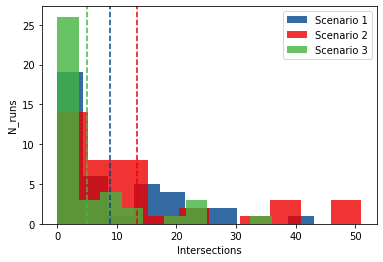

In [79]:
plt.hist(sc1_intersection,color=colors[0],label="Scenario 1",alpha=0.8)
plt.hist(sc2_intersection,color=colors[1],label="Scenario 2",alpha=0.8)
plt.hist(sc3_intersection,color=colors[2], label="Scenario 3",alpha=0.8)
plt.xlabel("Intersections")
plt.ylabel("N_runs")
plt.legend()
plt.axvline(np.mean(sc1_intersection),c=colors[0],linestyle="--")
plt.axvline(np.mean(sc2_intersection),c=colors[1],linestyle="--")
plt.axvline(np.mean(sc3_intersection),c=colors[2],linestyle="--")

## Not probabilistic
A design of experiment approach based on Generalized Subset Design as described 

Surowiec, I., Vikstrom, L., Hector, G., Johansson, E., Vikstrom, C., & Trygg, J. (2017). Generalized subset designs in analytical chemistry. Analytical chemistry, 89(12), 6491-6497.

In [155]:
import pyDOE2
def scenario4(levels,reduction):
    #A fractional factorial approach
    scenario4=pyDOE2.gsd(levels,reduction)

    sc4=np.zeros((np.shape(scenario4)[0],np.shape(scenario4)[1]))
    dictionary_for_sc4={0:1, 1:0.25 ,2:4 }
    for i in range(np.shape(scenario4)[0]):
        for j in range(np.shape(scenario4)[1]):
            sc4[i,j]=dictionary_for_sc4[scenario4[i,j]]
    enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
               "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
    my_designs=[]
    cart=[]
    for i in range(len(sc4)):
        my_designs.append(dict(zip(enz_names,sc4[i])))
        cart.append(tuple(sc4[i]))
    return my_designs,cart  



sc4_designs,sc4_cart=scenario4([3,3,3,3,3,3,3],9)

In [156]:
training_scenario4,training_cart=find_set_designs(comb_space,sc4_cart,enz_names) 

sc4_train_X=training_scenario4[enz_names]
sc4_train_Y=training_scenario4['Enzyme_G']

# log-uniform: understand as search over p = exp(x) by varying x
GBR_optimized = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        "criterion":("friedman_mse","squared_error"),
        "min_samples_split":(2,3,4,5,6),
        "min_samples_leaf":(1,2,3,4,5,6,7,8),
        "max_depth":(2,3,4,5,6,7,8),
        "max_features":(1,2,3,4,5,6,7,8),

    },
    n_iter=25,
    cv=5)


0.6986836252781772


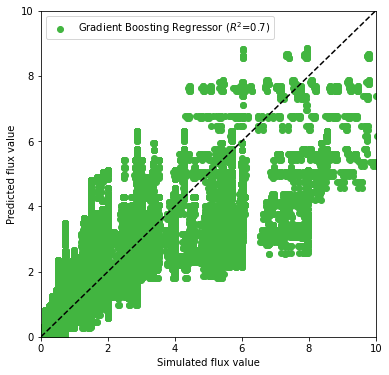

In [157]:
GBR_optimized.fit(sc4_train_X, sc4_train_Y)
sc4_predict=GBR_optimized.predict(c_test_X)
slope, intercept, r_value, p_value, std_err = linregress(c_test_Y,sc4_predict)
print(r_value**2)


fig, axs = plt.subplots(figsize=(6,6))
#plt.scatter(test_Y,pred_mlr,c="#ED0000FF",label="Multiple Linear Model ($R^2$="+str(np.round(score_mlr,2))+")")
#plt.scatter(test_Y,predict_GradBoostReg,c="#00468BFF",
          #  label="Gradient Boosting Tree ($R^2$="+str(np.round(score_GradBoost,2))+")")
plt.scatter(c_test_Y,sc4_predict,c="#42B540FF",
            label="Gradient Boosting Regressor ($R^2$="+str(np.round(r_value**2,2))+")")

#plt.scatter(test_y,predicted_xgb,label="XGboost")
#plt.scatter(test_y,pred_clf,label="Neural Network")
plt.xlabel("Simulated flux value")
plt.ylabel("Predicted flux value")
plt.axline((0, 0), slope=1,color="black",linestyle="--")
plt.ylim(0,10)
plt.xlim(0,10)
plt.legend()

35


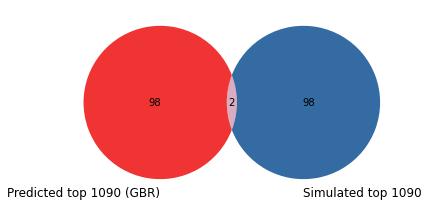

In [158]:
# Latin hypercube sampling
# Gradient Boosting Regressor
top100_predicted_gbr=np.argsort(sc4_predict)[::-1][0:100]
top100_simulated_gbr=np.argsort(comb_space['Enzyme_G'])[::-1][0:100]
sc4_intersect=np.intersect1d(top100_predicted_gbr,top100_simulated_gbr)
print(len(sc4_intersect))


#import matplotlib.pyplot as plt
#from matplotlib_venn import venn2
# Use the venn2 function
v=venn2(subsets = (100-35, 100-35, 35), set_labels = ('Predicted top 1090 (GBR)', 'Simulated top 1090'),
      set_colors=["#ED0000FF","#00468BFF"],normalize_to=1)
v.get_patch_by_id('10').set_alpha(0.8)
v.get_patch_by_id('01').set_alpha(0.8)